In [1]:
import os
import pydicom
import numpy as np
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm

# Define the path to the root directory containing DICOM folders
dicom_root = '/gpfs/data/mankowskilab/HCC_Recurrence/dicom'

Matplotlib created a temporary cache directory at /tmp/matplotlib-0d3ofxfg because the default path (/gpfs/home/wz1492/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [12]:
# Function to get all DICOM file paths
def get_dicom_files(root_dir):
    dicom_files = []
    for root, _, files in os.walk(root_dir):
        for file in sorted(files, key=lambda x: int(os.path.splitext(x)[0]) if x[:-4].isdigit() else x):  # Sort numerically if possible
            if file.endswith('.dcm'):
                dicom_files.append(os.path.join(root, file))
    return dicom_files
# Load DICOM files
dicom_files = get_dicom_files(dicom_root)
print(f"Found {len(dicom_files)} DICOM files.")

Found 139322 DICOM files.


In [13]:
print(dicom_files[:5])

['/gpfs/data/mankowskilab/HCC_Recurrence/dicom/9023679/1.dcm', '/gpfs/data/mankowskilab/HCC_Recurrence/dicom/9023679/2.dcm', '/gpfs/data/mankowskilab/HCC_Recurrence/dicom/9023679/3.dcm', '/gpfs/data/mankowskilab/HCC_Recurrence/dicom/9023679/4.dcm', '/gpfs/data/mankowskilab/HCC_Recurrence/dicom/9023679/5.dcm']


In [14]:
# Read metadata from the first few files for inspection
for i, dicom_file in enumerate(dicom_files[:5]):
    dataset = pydicom.dcmread(dicom_file)
    print(f"File: {dicom_file}")
    print(f"Patient ID: {dataset.PatientID}")
    print(f"Modality: {dataset.Modality}")
    print(f"Study Date: {dataset.StudyDate}")
    print(f"Image Dimensions: {dataset.Rows}x{dataset.Columns}")
    print("-" * 50)

File: /gpfs/data/mankowskilab/HCC_Recurrence/dicom/9023679/1.dcm
Patient ID: 9134161
Modality: MR
Study Date: 20140521
Image Dimensions: 256x256
--------------------------------------------------
File: /gpfs/data/mankowskilab/HCC_Recurrence/dicom/9023679/2.dcm
Patient ID: 9134161
Modality: MR
Study Date: 20140521
Image Dimensions: 256x256
--------------------------------------------------
File: /gpfs/data/mankowskilab/HCC_Recurrence/dicom/9023679/3.dcm
Patient ID: 9134161
Modality: MR
Study Date: 20140521
Image Dimensions: 256x256
--------------------------------------------------
File: /gpfs/data/mankowskilab/HCC_Recurrence/dicom/9023679/4.dcm
Patient ID: 9134161
Modality: MR
Study Date: 20140521
Image Dimensions: 256x256
--------------------------------------------------
File: /gpfs/data/mankowskilab/HCC_Recurrence/dicom/9023679/5.dcm
Patient ID: 9134161
Modality: MR
Study Date: 20140521
Image Dimensions: 256x256
--------------------------------------------------


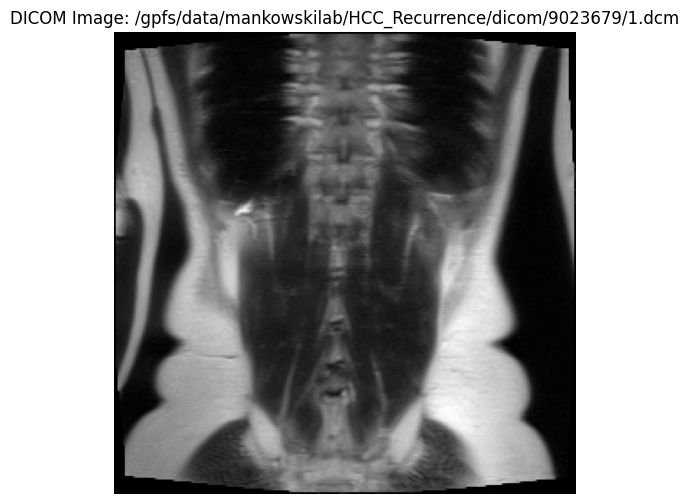

In [15]:
# Visualize the first DICOM image
first_image = pydicom.dcmread(dicom_files[0])

plt.figure(figsize=(6, 6))
plt.imshow(first_image.pixel_array, cmap='gray')
plt.title(f"DICOM Image: {dicom_files[0]}")
plt.axis('off')
plt.show()

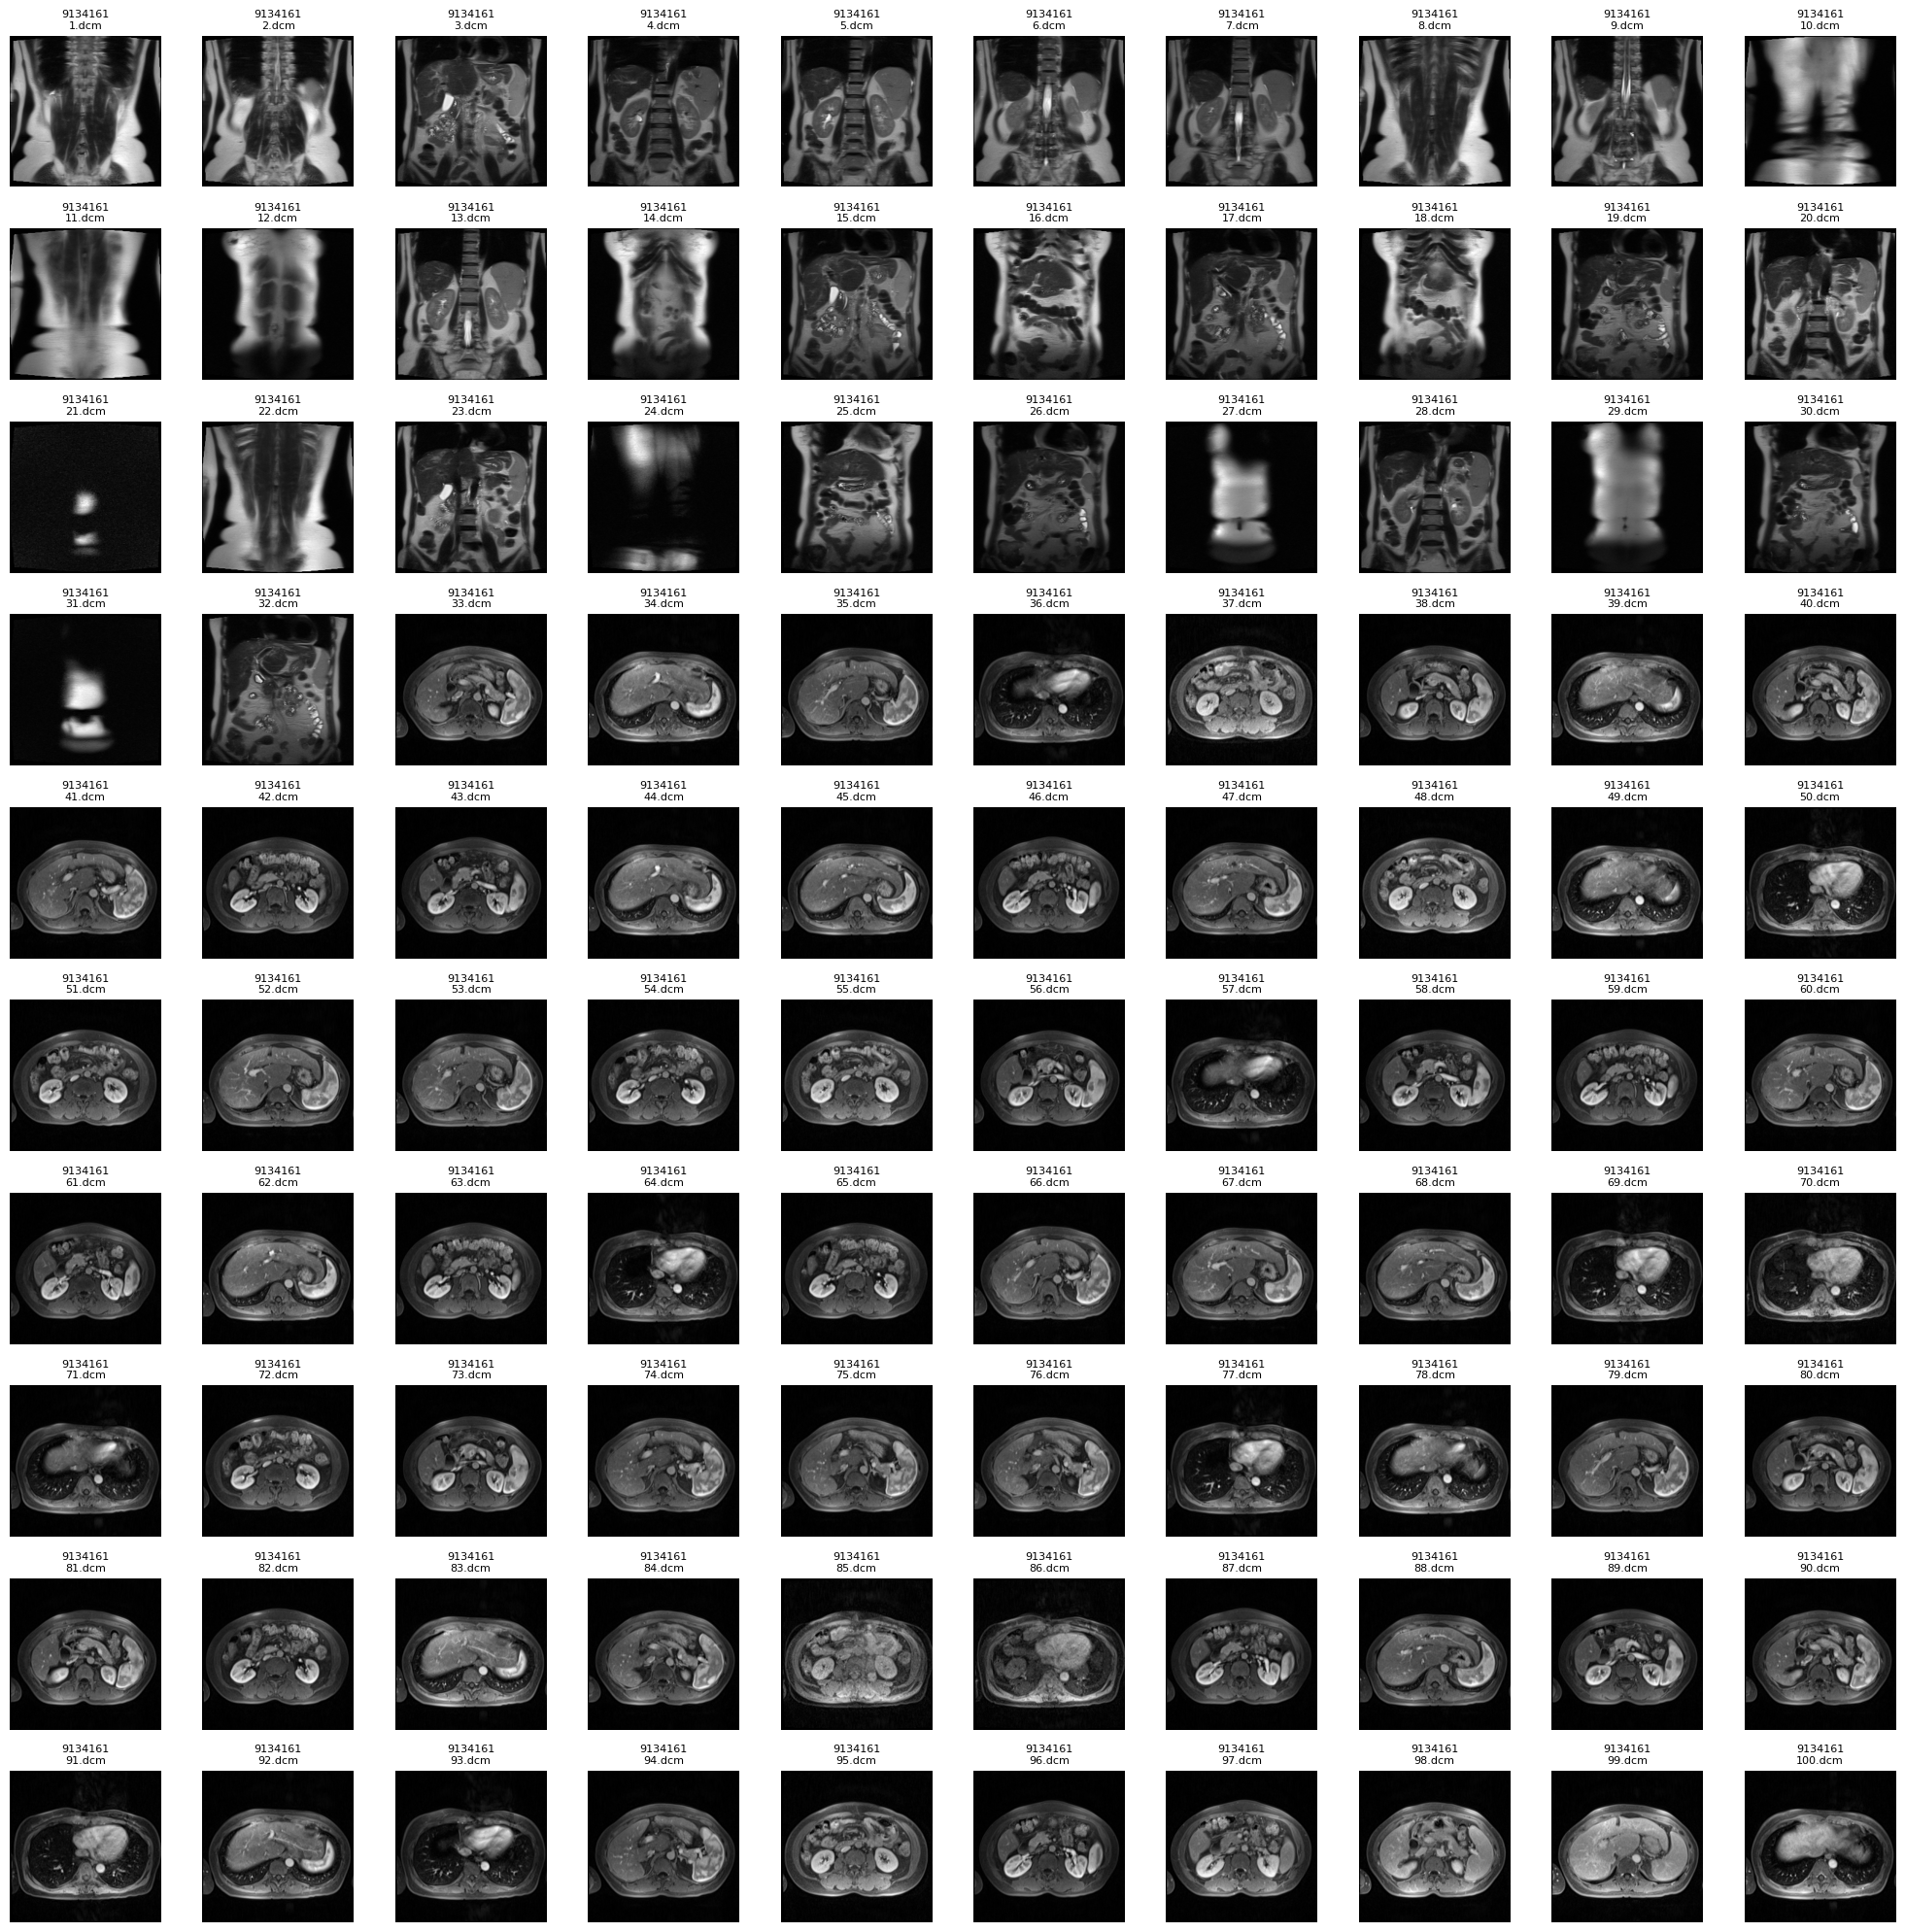

In [26]:
def visualize_dicom_images(dicom_files, num_images=100):
    grid_size = int(np.ceil(np.sqrt(num_images)))
    plt.figure(figsize=(grid_size * 2, grid_size * 2))
    for i, dicom_file in enumerate(dicom_files[:num_images]):
        dataset = pydicom.dcmread(dicom_file)
        patient_id = dataset.PatientID if 'PatientID' in dataset else "Unknown"
        plt.subplot(grid_size, grid_size, i + 1)
        plt.imshow(dataset.pixel_array, cmap='gray')
        plt.title(f"{patient_id}\n{os.path.basename(dicom_file)}", fontsize=8)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Visualize the first 100 images
visualize_dicom_images(dicom_files, num_images=100)

In [25]:
# Function to extract detailed statistics about the dataset
def get_dataset_stats(dicom_files):
    modalities = {}
    dimensions = {}
    manufacturers = {}
    body_parts = {}

    def process_file(dicom_file):
        dataset = pydicom.dcmread(dicom_file)
        modality = dataset.Modality
        dimensions_key = (dataset.Rows, dataset.Columns)
        manufacturer = dataset.Manufacturer if 'Manufacturer' in dataset else "Unknown"
        body_part = dataset.BodyPartExamined if 'BodyPartExamined' in dataset else "Unknown"
        return modality, dimensions_key, manufacturer, body_part

    with ThreadPoolExecutor() as executor:
        results = list(tqdm(executor.map(process_file, dicom_files), total=len(dicom_files), desc="Processing DICOM files"))

    for modality, dimensions_key, manufacturer, body_part in results:
        # Count modalities
        if modality not in modalities:
            modalities[modality] = 0
        modalities[modality] += 1

        # Count image dimensions
        if dimensions_key not in dimensions:
            dimensions[dimensions_key] = 0
        dimensions[dimensions_key] += 1

        # Count manufacturers
        if manufacturer not in manufacturers:
            manufacturers[manufacturer] = 0
        manufacturers[manufacturer] += 1

        # Count body parts examined
        if body_part not in body_parts:
            body_parts[body_part] = 0
        body_parts[body_part] += 1

    return modalities, dimensions, manufacturers, body_parts

# Get and display dataset statistics
modalities, dimensions, manufacturers, body_parts = get_dataset_stats(dicom_files)

print("Modality distribution:")
for modality, count in modalities.items():
    print(f"  {modality}: {count} images")

print("\nImage dimensions distribution:")
for dim, count in dimensions.items():
    print(f"  {dim}: {count} images")

print("\nManufacturer distribution:")
for manufacturer, count in manufacturers.items():
    print(f"  {manufacturer}: {count} images")

print("\nBody parts examined distribution:")
for body_part, count in body_parts.items():
    print(f"  {body_part}: {count} images")

Processing DICOM files: 100%|██████████| 139322/139322 [08:40<00:00, 267.88it/s]


Modality distribution:
  MR: 139218 images
  US: 103 images
  CR: 1 images

Image dimensions distribution:
  (256, 256): 55726 images
  (288, 384): 1788 images
  (240, 256): 2548 images
  (224, 256): 2227 images
  (128, 128): 476 images
  (208, 256): 5425 images
  (416, 512): 264 images
  (132, 160): 3872 images
  (384, 384): 1162 images
  (512, 512): 4544 images
  (124, 160): 288 images
  (290, 320): 1702 images
  (320, 320): 3902 images
  (232, 256): 21365 images
  (120, 160): 4055 images
  (160, 160): 280 images
  (352, 512): 1323 images
  (368, 512): 102 images
  (256, 224): 66 images
  (512, 352): 112 images
  (144, 192): 274 images
  (192, 192): 651 images
  (291, 512): 1442 images
  (260, 320): 3280 images
  (358, 512): 1778 images
  (264, 320): 752 images
  (302, 512): 450 images
  (366, 512): 545 images
  (128, 160): 661 images
  (48, 64): 1 images
  (336, 384): 100 images
  (208, 268): 184 images
  (200, 268): 96 images
  (216, 268): 200 images
  (384, 512): 212 images
  (192